# TODO: README, run in JupyterLab

# Effect of threshold in model accuracy

This notebook shows the effect of choosing thresholds for the softmax layer in classification problems.

Model accuracy is usually reported as:

```text
     Number of correct predictions on the test set
   -------------------------------------------------
       Total number of instances in the test set
```

But how do we determine what a "correct prediction" is?

The usual approach is to choose the label that has the maximum predicted probability:

```python
    predicted_probability = model.predict(ds_test)
    predicted_label = np.argmax(predicted_probability, axis=1)
```

However, this method glosses over two important factor:

1. Two or more classes may have very close predicted probabilities.
1. Some applications require the model to be 

To address both items we need to use thresholds to decide when a prediction is correct. For example, in high-stakes applications, we may require the model to be at least 90% certain of a prediction to accept it as correct.

Using the MNIST dataset, we will investigate the effect of settings thresholds for predictions on the accuracy of models.

Sources:

- [Tensorflow MNIST example](https://www.tensorflow.org/datasets/keras_example)
- [Keras MNIST example](https://keras.io/examples/vision/mnist_convnet/)
- [Multi-label vs. Multi-class Classification: Sigmoid vs. Softmax](https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)
- [Interpreting logits: sigmoid vs softmax](https://web.stanford.edu/~nanbhas/blog/sigmoid-softmax.html)

In [1]:
import random
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

To increase reproducibility (but still not guaranteed to get exactly the same results because of parallelism and GPU usages).

References:

- [Stackoverflow](https://stackoverflow.com/a/53760258)
- [Tensorflow `set_seed`](https://www.tensorflow.org/api_docs/python/tf/random/set_seed)

In [2]:
SEED=1234
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## Load MNIST and create the training/test pipelines

The code in this section is from the [TensorFlow MNIST example](https://www.tensorflow.org/datasets/keras_example).

Load MNIST.

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

Build training pipeline.

In [4]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

Build test pipeline.

In [5]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

## Train a model

The model is a simple network of dense layers that can achieve about 98% accuracy in less than one minute of training.

This accuracy is enough for the experiments. We are interested in the effect of using different thresholds with softmax, not on very high accuracy for the model.

In [6]:
NUM_CLASSES = 10
INPUT_SHAPE = (28, 28)
ACTIVATION='relu'

In [7]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=INPUT_SHAPE),
  tf.keras.layers.Dense(512, activation=ACTIVATION),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation=ACTIVATION),
  tf.keras.layers.Dropout(0.25),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

Train the model using early stopping to get a decent model without investing too much time in training. The main purspose of this notebook is not to get high accuracy. It's to demonstrate the effect of softmax thresholds.

In [8]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2, verbose=1,
    restore_best_weights=True)

model.fit(
    ds_train, epochs=10,
    validation_data=ds_test,
    callbacks=[callback]
)

Epoch 1/10
469/469 [==============================] - 5s 7ms/step - loss: 0.5145 - sparse_categorical_accuracy: 0.8392 - val_loss: 0.1353 - val_sparse_categorical_accuracy: 0.9558
Epoch 2/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9520 - val_loss: 0.0961 - val_sparse_categorical_accuracy: 0.9710
Epoch 3/10
469/469 [==============================] - 2s 5ms/step - loss: 0.1225 - sparse_categorical_accuracy: 0.9632 - val_loss: 0.0848 - val_sparse_categorical_accuracy: 0.9743
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.1072 - sparse_categorical_accuracy: 0.9688 - val_loss: 0.0864 - val_sparse_categorical_accuracy: 0.9758
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0943 - sparse_categorical_accuracy: 0.9725 - val_loss: 0.0801 - val_sparse_categorical_accuracy: 0.9770
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0839 - sparse_categorica

## Analyze predictions on the test set

This section shows some digits that were correctly predicted and some that were misclassified.

The goal is to visually check if the model is indeed working before.

The actual labels and images 
from the test set.

In [9]:
test_label = np.concatenate([y for _, y in ds_test], axis=0)
test_image = np.concatenate([x for x, _ in ds_test], axis=0)

The model's predicted probabilities and labels (using the maximum predicted probability).

In [10]:
predicted_probability = model.predict(ds_test)
predicted_label = np.argmax(predicted_probability, axis=1)

# Basic sanity checks
assert len(test_label) == len(predicted_label)

Visualize some digits that were predicted correclty.

In [11]:
def draw_one_digit(ax, digit_index, digit_images, title=None):
    """Draw the image of a digit, given its index into an array of images."""
    ax.axis('off')
    ax.imshow(digit_images[digit_index], cmap=plt.get_cmap('Greys'))
    ax.set_title(title)

In [12]:
# Inspired by https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e
import math

def draw_digits(digit_indices):
    """ Draw digits selected from the test dataset, given their indices."""
    number_of_digits = len(digit_indices)
    _, ax = plt.subplots(1, number_of_digits, figsize=(8, 8))
    for c in range(number_of_digits):
        digit_index = digit_indices[c]
        title = "{}: {}/{}".format(digit_index, test_label[digit_index],
            predicted_label[digit_index])
        draw_one_digit(ax[c], digit_index, test_image, title)
    plt.tight_layout()
    plt.show()

In [13]:
# Get indices of all instaces correctly classified
correct_index = [i for i in np.arange(len(predicted_label)) 
                    if predicted_label[i] == test_label[i]]

# Get indices of all misclassfied instaces
misclassified_index = [i for i in np.arange(len(predicted_label)) 
                        if predicted_label[i] != test_label[i]]

# Sanity check
assert (len(correct_index) + len(misclassified_index)) == len(test_label)

print('Found {:,} correctly classified and {:,} misclassified instances'.format(
    len(correct_index), len(misclassified_index)))

Found 9,791 correctly classified and 209 misclassified instances


Samples of correctly classified digits. The numbers above each digit show the digit index in the test set, the test label, and the (in this case, correct) predicted label.

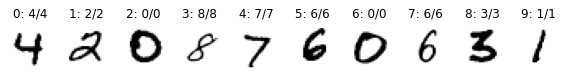

In [14]:
draw_digits(correct_index[:10])

Samples of misclassified digits. The correct and predicted labelz are shown above each digit (correct/predicted).

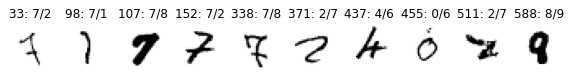

In [15]:
draw_digits(misclassified_index[:10])

## Correctly classified, by a large margin

When choosing a class, we have so far simply asked for the maximum probability:

`predicted_label = np.argmax(predicted_probability, axis=1)`

For example, here are the probabilities for one of the digits in the test set:

In [21]:
SAMPLE_DIGIT = 1
print(predicted_probability[SAMPLE_DIGIT])

[2.0730225e-15 7.8476427e-11 1.0000000e+00 8.2398435e-09 1.7356503e-11
 1.7447924e-10 1.8910654e-11 1.6929447e-09 1.1119339e-10 1.3290108e-12]


And here is what `argmax` returns:

In [23]:
print('Model predicted digit {}'.format(
    np.argmax(predicted_probability[SAMPLE_DIGIT])))

Model predicted digit 2


Here is the image, showing that it was indeed a correct prediction.

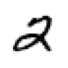

In [24]:
_, ax = plt.subplots(figsize=(1, 1))
ax.imshow(test_image[SAMPLE_DIGIT], cmap=plt.get_cmap('Greys'))
plt.axis('off');

In this case, the model is certain that this is the correct digit by orders of magnitude.

Here are the probabilities again. Compare the probability for the index that matches the prediction (index = 2, matching the digit 2) in the array for the correct prediction with the probabilities for thet the other indices.

In [25]:
print(predicted_probability[SAMPLE_DIGIT])

[2.0730225e-15 7.8476427e-11 1.0000000e+00 8.2398435e-09 1.7356503e-11
 1.7447924e-10 1.8910654e-11 1.6929447e-09 1.1119339e-10 1.3290108e-12]


## Correctly classified, by a slimmer margin

But we also have cases where the "winning" prediction does not have such a large margin.

In this section we will review some correct classifications whose largest probability was not above 50%. This indicates that the model was not certain about the prediction.

First, auxiliary functions to draw the model's prediction histogram and the digits.

In [40]:
from matplotlib.ticker import NullFormatter

def draw_prediction_histogram(ax, class_probabilities, hide_y_labels):
    """Draw a histogram of the predicted probabilities for each class and format for easier reading."""
    classes = np.arange(NUM_CLASSES)
    
    # Show all graphs in the same scale, to allow comparison
    ax.set_ylim(0, 100)

    # Draw the bars and show the class (digit) above each one
    bars = ax.bar(classes, class_probabilities*100) # Show in % (nicer labels for the y axis)
    for digit, bar in zip(classes, bars):
        yval = bar.get_height()
        ax.text(bar.get_x() - 0.25, yval + 3, digit)

    # Remove all tick marks, the bottom labels (already show class above the bar) and suppress
    # the y label for zero on the left corner to avoid confusion with the class - also zero
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticks([])
    ax.set_yticks([25, 50, 75, 100])
    
    # Hide the y axis label if so requested (to make it look cleaner, show y labels only for
    # the first graph [left] in the row)
    if hide_y_labels:
        ax.yaxis.set_major_formatter(NullFormatter())

    # Show faint grid lines behind the bars
    ax.yaxis.grid(color='grey', alpha=0.25)
    ax.set_axisbelow(True)
    
    # Leave only the bottom spine visible, so the bars aren't "floating in space"
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [43]:
def draw_digits_histogram(digit_indices):
    """ Draw digits and histogram of probaility predictions.

    Assumes that arrays with predicted classes and predicted probabilities have already
    been populated elsewhere .
    """
    number_of_digits = len(digit_indices)
    num_cols = 10
    num_rows = math.ceil(number_of_digits / num_cols)

    # Subplots with twice as many rows as we calculated above because we will show a histogram
    # of the predictions below each digit. The histogram is twice as tall as the digit (the
    # gridspec_kw values).
    f, ax = plt.subplots(num_rows*2, num_cols, figsize=(12, 3*num_rows),
                         gridspec_kw = {'height_ratios':np.tile([1,2], num_rows)})

    for r in range(num_rows):
        for c in range(num_cols):
            image_index = r * num_cols + c
            if image_index < number_of_digits:
                digit_index = digit_indices[image_index]
                title = "{}: {}/{}".format(digit_index, test_label[digit_index],
                    predicted_label[digit_index])
                draw_one_digit(ax[r*2,c], digit_index, test_image, title)
                draw_prediction_histogram(ax[r*2+1,c], predicted_probability[digit_index], c > 0)
            else:
                # Turn off the spines to show an empty space in incomplete rows
                ax[r*2,c].axis('off')
                ax[r*2+1,c].axis('off')

    plt.tight_layout()
    plt.show()

Now, find the digits that have been predicted with less than 50% confidence.

In [33]:
THRESHOLD = 0.5

max_predicted_probabiliy = np.max(predicted_probability, axis=1)
correct_prediction = predicted_label == test_label

probability_le_threshold = [i for i in correct_index if
                            correct_prediction[i] and 
                            max_predicted_probabiliy[i] <= THRESHOLD]
probability_gt_threshold = [i for i in correct_index if
                            correct_prediction[i] and 
                            max_predicted_probabiliy[i] > THRESHOLD]

# A few sanity checks
num_le_threshold = len(probability_le_threshold)
num_gt_threshold = len(probability_gt_threshold)
assert (num_le_threshold + num_gt_threshold) == len(correct_index)

num_correct_predicted = sum(correct_prediction)
assert num_correct_predicted == len(correct_index)

Show some statistics.

In [36]:
print('Out of {:,} correctly classified digit, for the {:.0%} threshold:'.format(
    num_correct_predicted, THRESHOLD))
print('  {:,} digits are above the threshold'.format(num_gt_threshold))
print('  {:,} are at or below the threshold'.format(num_le_threshold))

Out of 9,791 correctly classified digit, for the 50% threshold:
  9,778 digits are above the threshold
  13 are at or below the threshold


[8.1867132e-05 1.7243630e-04 6.0347852e-04 9.5981057e-04 1.1805989e-06
 1.4952662e-04 3.4361026e-05 1.8922703e-05 9.9787247e-01 1.0604714e-04]
0.9978725
8
8


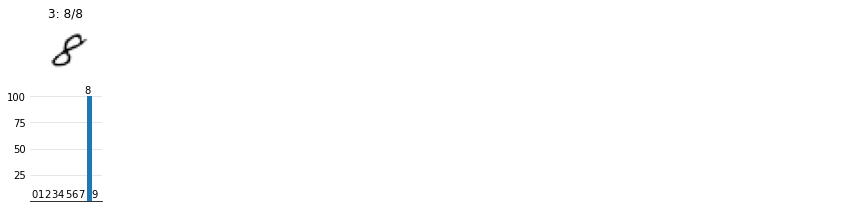

In [44]:
TEST_DIGIT = 3
print(predicted_probability[TEST_DIGIT])
print(np.max(predicted_probability[TEST_DIGIT]))
print(np.argmax(predicted_probability[TEST_DIGIT]))
print(predicted_label[TEST_DIGIT])
draw_digits_histogram([TEST_DIGIT])

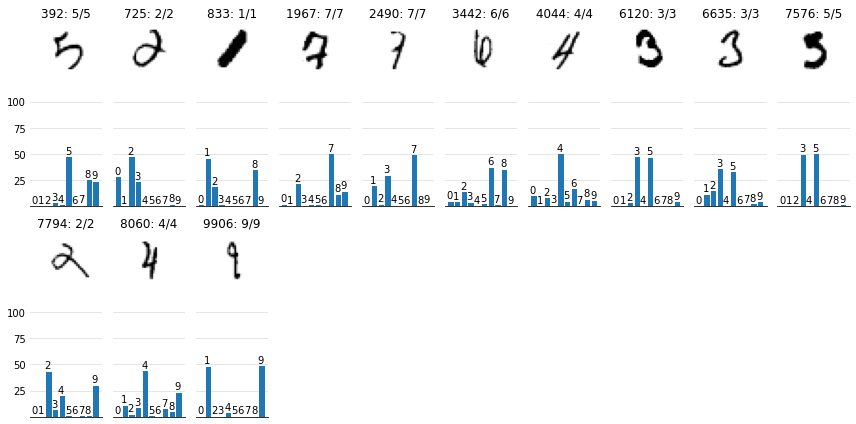

In [45]:
draw_digits_histogram(probability_le_threshold[:100])

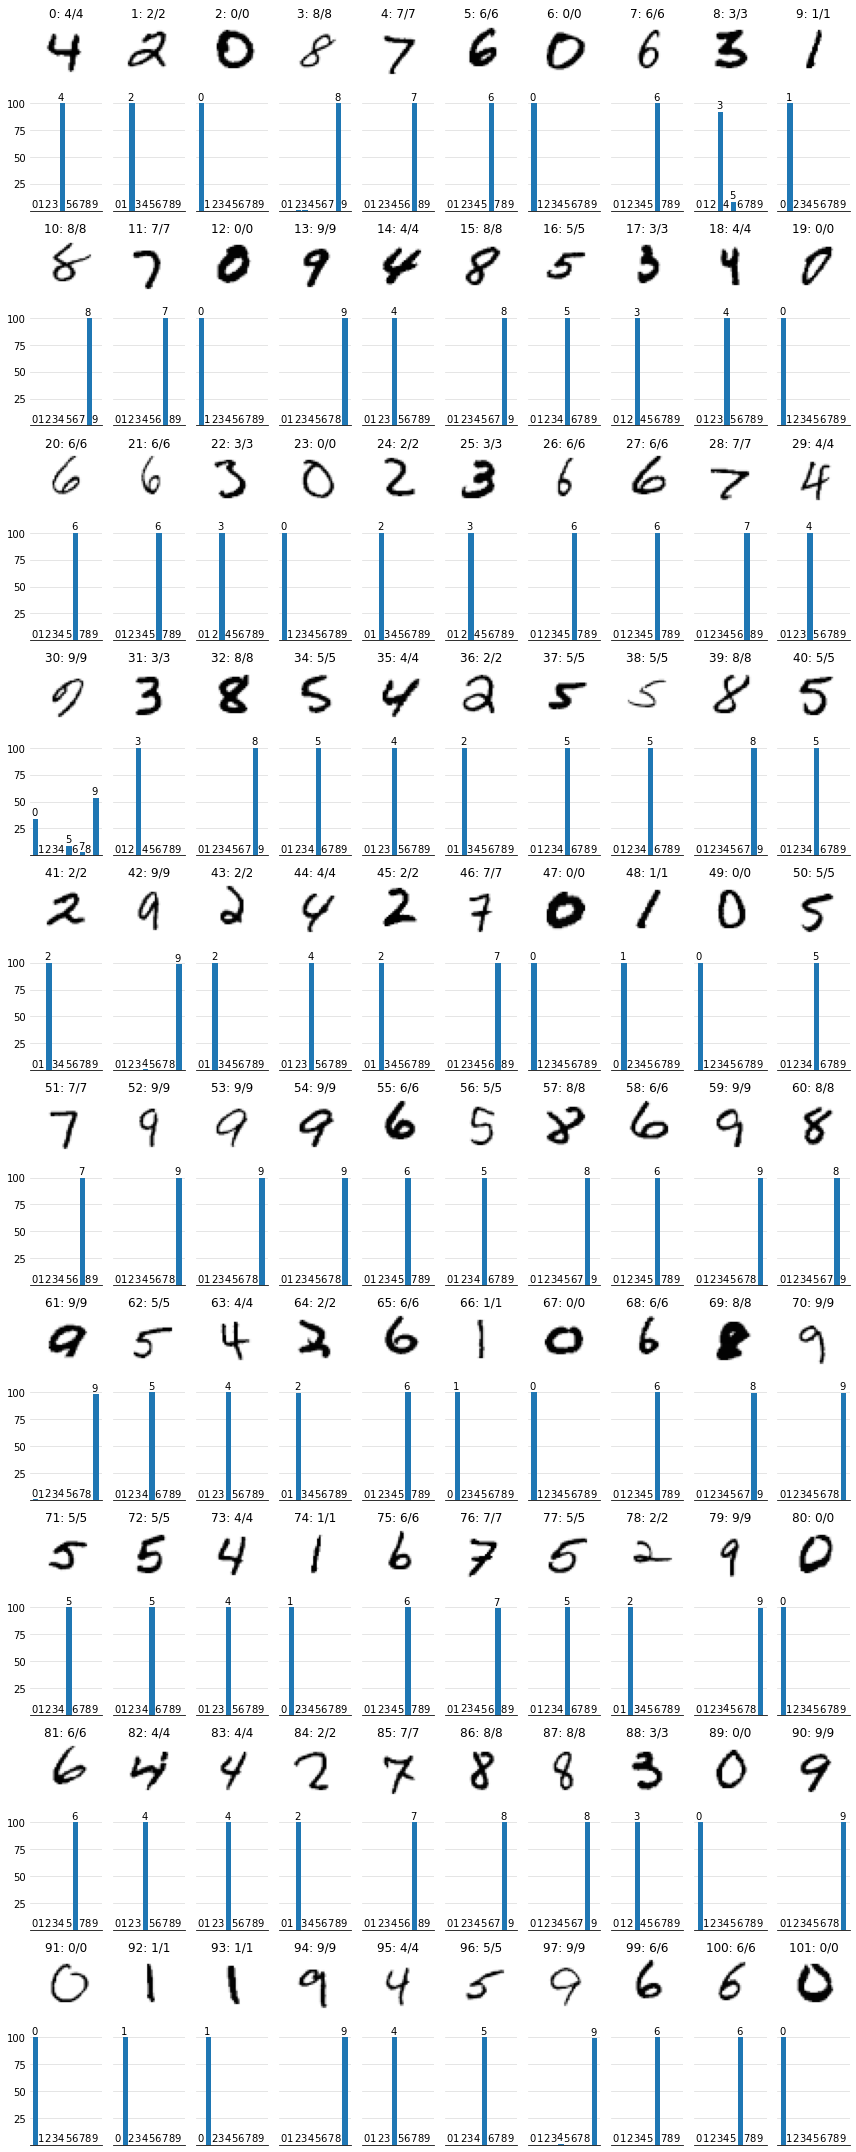

In [46]:
draw_digits_histogram(probability_gt_threshold[:30])